<a href="https://colab.research.google.com/github/Codeblockz/Data-Science-Self-Projects/blob/main/Kaggle_Titanic_challege/Titanic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Titanic Challenge Kaggle <br></br>
[source 1](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)  <br></br>
[source 2]( https://www.kaggle.com/lonnieqin/classification-with-sklearn-and-tensorflow)

In [55]:
# from google.colab import files
# from os.path import exists
# file_exists = exists("/content/kaggle.json")
# if (file_exists==False):
#   files.upload()

In [56]:
%cd /content/drive/MyDrive/Colab Notebooks/Titanic

/content/drive/MyDrive/Colab Notebooks/Titanic


In [57]:
! pip install -q kaggle
!pip install --upgrade kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [58]:
 ! kaggle competitions download titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


Start To work on geting data

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import string
import copy

In [60]:
# Load Data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check For Nulls


In [61]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [62]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Check Data Types

In [63]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [64]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Data Scrubing Replacing NAN values

In [65]:
# from source 2
# Replace NAN
embark_label = train["Embarked"].mode()[0]
train["Cabin"] = train["Cabin"].replace(np.NAN,  "Unknown")
train["Embarked"] = train["Embarked"].replace(np.NAN, embark_label)
train["Age"] = train["Age"].replace(np.NAN, train["Age"].mean())

# Test Replace
test["Cabin"] = test["Cabin"].replace(np.NAN, "Unknown")
test["Age"] = test["Age"].replace(np.NAN, test["Age"].mean())
test["Fare"] = test["Fare"].replace(np.NAN, test["Fare"].mean())

In [66]:
# source 1
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string) # For debug check
    return np.nan
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle',
            'Col', 'Capt', 'Mme', 'Countess', 'Don', 'Jonkheer']
train['Title']=train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
# Apply function to data
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)


In [67]:
# data check
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Miss
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mrs
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mr


In [68]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr


In [69]:
# Make cabin type
# Source 2
train['Cabin_type'] = train["Cabin"].apply(lambda cabin: cabin[0])
test["Cabin_type"] = test["Cabin"].apply(lambda cabin: cabin[0])
# Make New Label
train["family_member_size"] = 1 + train["SibSp"] + train["Parch"]
test["family_member_size"] = 1 + test["SibSp"] + test["Parch"]

In [70]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,U,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,U,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,U,1


In [71]:
# data check 
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,U,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,U,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Miss,U,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mrs,U,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mr,U,3


The correlation bellow shows that Family size is not linearly related however there is a relationship between survival and family size

In [72]:
# make encoded values
encode_vals = ['Sex','Cabin_type','Embarked']
def make_encode_num(val, data):
  for feature in val:
    data[feature]=data[feature].astype('category')
    data[feature+'_value']=data[feature].cat.codes
  return data
train=make_encode_num(encode_vals, train)
test = make_encode_num(encode_vals, test)

In [73]:
# data check
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size,Sex_value,Cabin_type_value,Embarked_value
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,U,2,1,8,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,U,1,0,8,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2,0,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,U,1,1,8,2


In [74]:
# data check
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_type,family_member_size,Sex_value,Cabin_type_value,Embarked_value
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Unknown,Q,Mr,U,1,1,7,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,Unknown,S,Mrs,U,2,0,7,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Unknown,Q,Miss,U,1,1,7,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,Unknown,S,Mrs,U,1,1,7,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,Unknown,S,Mr,U,3,0,7,2


In [76]:
# make one hot encoding
# I only relized after I made the function how bad the naming was
def one_hot_tit(data, labels):
  for label in labels:
    temp = data[label]
    data= pd.get_dummies(data, columns=[label])
    data[label]=temp
  return data
temp = copy.copy(train)
temp=one_hot_tit(temp, encode_vals)
temp.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,family_member_size,Sex_value,Cabin_type_value,Embarked_value,Sex_female,Sex_male,Sex,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_U,Cabin_type,Embarked_C,Embarked_Q,Embarked_S,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Unknown,Mr,2,1,8,2,0,1,male,0,0,0,0,0,0,0,0,1,U,0,0,1,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,Mrs,2,0,2,0,1,0,female,0,0,1,0,0,0,0,0,0,C,1,0,0,C
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Unknown,Miss,1,0,8,2,1,0,female,0,0,0,0,0,0,0,0,1,U,0,0,1,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,Mrs,2,0,2,2,1,0,female,0,0,1,0,0,0,0,0,0,C,0,0,1,S
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Unknown,Mr,1,1,8,2,0,1,male,0,0,0,0,0,0,0,0,1,U,0,0,1,S


In [77]:
temp.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived              1.000000
Sex_male             -0.543351
Sex_female            0.543351
Sex_value            -0.543351
Pclass               -0.338481
Cabin_type_U         -0.316912
Cabin_type_value     -0.301116
Fare                  0.257307
Cabin_type_B          0.175095
Embarked_C            0.168240
Embarked_value       -0.167675
Cabin_type_D          0.150716
Embarked_S           -0.149683
Cabin_type_E          0.145321
Cabin_type_C          0.114652
Parch                 0.081629
Age                  -0.069809
Cabin_type_F          0.057935
SibSp                -0.035322
Cabin_type_T         -0.026456
Cabin_type_A          0.022287
family_member_size    0.016639
Cabin_type_G          0.016040
PassengerId          -0.005007
Embarked_Q            0.003650
Name: Survived, dtype: float64

## Survival Factors

In [30]:
# source 2
train.corr()["Survived"].sort_values(key=lambda x: abs(x), ascending=False)

Survived              1.000000
Sex_value            -0.543351
Pclass               -0.338481
Cabin_type_value     -0.301116
Fare                  0.257307
Embarked_value       -0.167675
Parch                 0.081629
Age                  -0.069809
SibSp                -0.035322
family_member_size    0.016639
PassengerId          -0.005007
Name: Survived, dtype: float64

In [52]:
# See what index Does
# index gives the feature values that equaled true
l=list(train.corr()[train.corr()["Survived"].abs()>.05] )
p=list(train.corr()[train.corr()["Survived"].abs()>.05].index )
print(len(l),"\n",l)
print(len(p),"\n",p)
res = [x for x in l + p if x not in l or x not in p]
print(res)

11 
 ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'family_member_size', 'Sex_value', 'Cabin_type_value', 'Embarked_value']
8 
 ['Survived', 'Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value']
['PassengerId', 'SibSp', 'family_member_size']


In [ ]:
# Source 2
related_columns = list(train.corr()[train.corr()["Survived"].abs() > 0.05].index)
related_columns.remove("Survived")
print(related_columns)

['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value']


In [ ]:
# For DNN
train_DNN = train[['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value']]
test_DNN = test[['Pclass', 'Age', 'Parch', 'Fare', 'Sex_value', 'Cabin_type_value', 'Embarked_value']]

## Deep and Wide

In [ ]:
categorical_feature_names = ["Pclass", "Sex_value", "Embarked_value", "Cabin_type_value"]
numerical_feature_names = ["Age", "Fare", "SibSp", "Parch", "family_member_size"]
categorical_features = [
    feature_column.indicator_column(
        feature_column.categorical_column_with_vocabulary_list(key, sorted(list(train[key].unique())))
    ) for key in categorical_feature_names
]
print(categorical_features)
numerical_features = [feature_column.numeric_column(key) for key in numerical_feature_names]
input_dictionary = dict()
inputs = dict()
for item in numerical_features:
    inputs[item.key] = tf.keras.layers.Input(name=item.key, shape=())
for item in categorical_features:
    #print(item.categorical_column.key)
    inputs[item.categorical_column.key] = tf.keras.layers.Input(name=item.categorical_column.key, shape=(), dtype="int32")

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex_value', vocabulary_list=(0, 1), dtype=tf.int8, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Embarked_value', vocabulary_list=(0, 1, 2), dtype=tf.int8, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Cabin_type_value', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8), dtype=tf.int8, default_value=-1, num_oov_buckets=0))]


In [ ]:
# Source 2 
# Helper Features
def features_and_labels(row_data):
    label = row_data.pop("Survived")
    features = row_data
    return features, label

def create_dataset(pattern, epochs=1, batch_size=32, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(features_and_labels)
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=128).repeat(epochs)
  # print(dataset)
    dataset = dataset.prefetch(1)
  # print("after prefetch\n",dataset)
    return dataset

def create_test_dataset(pattern, batch_size=32):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size
    )
    dataset = dataset.map(lambda features: features)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_data, val_data = train_test_split(
    train[categorical_feature_names + numerical_feature_names + ["Survived"]],
    test_size=.2,
    random_state=np.random.randint(0, 1000)
)
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test[categorical_feature_names + numerical_feature_names].to_csv("test_data.csv", index=False)
batch_size = 32
train_dataset = create_dataset("train_data.csv", batch_size=batch_size, mode='train')
val_dataset = create_dataset("val_data.csv", batch_size=val_data.shape[0], mode='eval').take(1)
test_dataset = create_test_dataset("test_data.csv", batch_size = test.shape[0]).take(1)

In [ ]:
# D&W Model
def build_deep_and_wide_model():
    deep = tf.keras.layers.DenseFeatures(numerical_features, name='deep')(inputs)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    deep = tf.keras.layers.Dense(16, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.3)(deep)
    wide = tf.keras.layers.DenseFeatures(categorical_features, name='wide')(inputs)
    wide = tf.keras.layers.Dense(32, activation='relu')(wide)
    combined = tf.keras.layers.concatenate(inputs=[deep, wide], name='combined')
    output = tf.keras.layers.Dense(1, activation="sigmoid")(combined)
    model = tf.keras.Model(inputs=list(inputs.values()), outputs=output)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

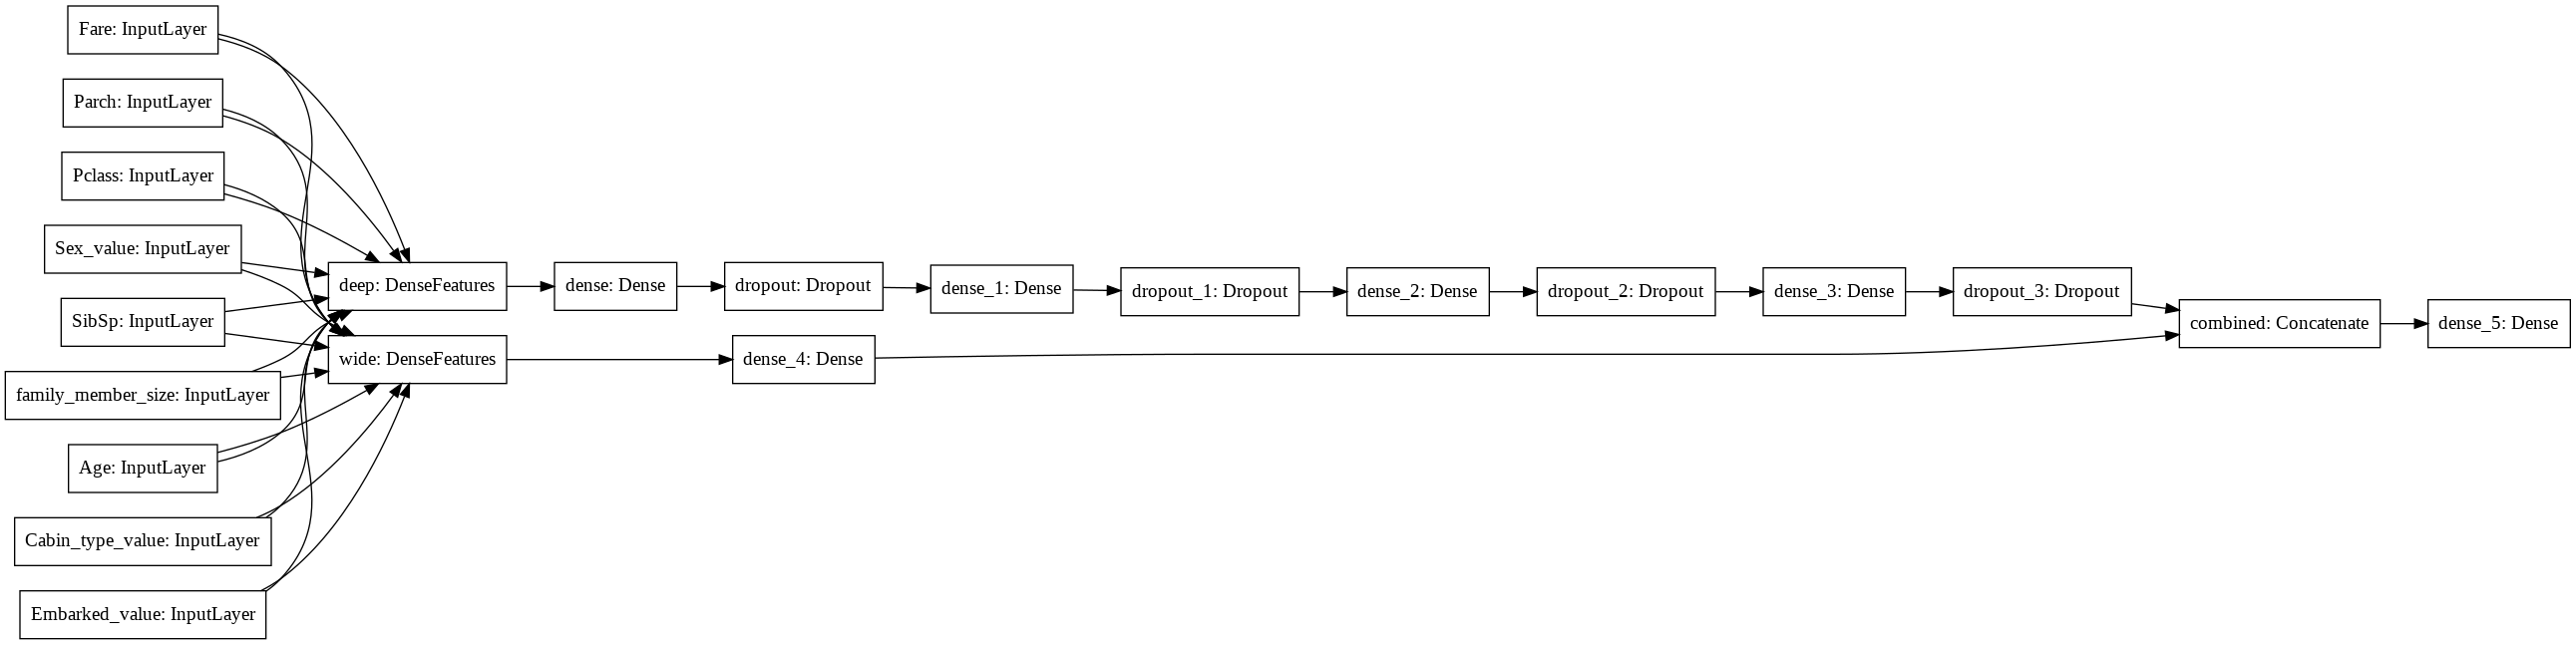

In [ ]:
deep_and_wide_model = build_deep_and_wide_model()
tf.keras.utils.plot_model(deep_and_wide_model, show_shapes=False, rankdir='LR')

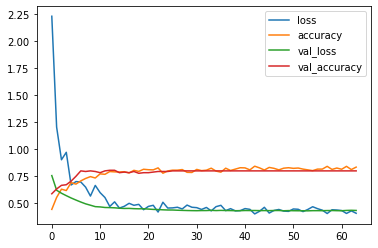

In [ ]:
epochs = 400
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
steps_per_epoch = train_data.shape[0] // batch_size
history = deep_and_wide_model.fit(
    train_dataset, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    verbose=0
)
pd.DataFrame(history.history).plot()

In [ ]:
# y_pred =  np.array(deep_and_wide_model.predict(val_dataset) > 0.5, dtype=int).reshape(-1)
y_pred = np.array(deep_and_wide_model.predict(val_dataset)>.5,dtype=int).reshape(-1)
score = accuracy_score(val_data["Survived"], y_pred)
# print("y_pred", y_pred)
print("Accuracy score:", score)
print(sklearn.metrics.classification_report(val_data["Survived"], y_pred))
Survived = np.argmax(deep_and_wide_model.predict(test_dataset), axis=-1).reshape(-1)
print(Survived.shape)

Accuracy score: 0.5642458100558659
              precision    recall  f1-score   support

           0       0.62      0.72      0.67       109
           1       0.42      0.31      0.36        70

    accuracy                           0.56       179
   macro avg       0.52      0.52      0.52       179
weighted avg       0.54      0.56      0.55       179

(418,)
